__Name__: Predictive Power of Indicator (v1.0)  
__Build by:__ Janderson FFerreira  
__Funny Name:__ Let's see you if are the holy grail, as you told us  
__Objetivos:__ Build a tool to capable of measure a predictive power of group of indicators for a group of stocks, this predictive is power is measure by the hability of indicator to predict the returns of 1,2,3 bars ahead   
__Where this ideia came from__: Book Quantitative Technical Analysis Band, Howard pg. 164-166  
__Created at__:  2020-05-29  
__Stocks__: PETR4, VALE3, ITUB4, Mini IBov index future (WIN$N) (Brazilian Market)  
__Source of Data__: Metatrader 5 Exchange XP Investimentos  

__Conclusions__:  
- This ideia of discretization a continuous variable (like rsi values) is very interesting and results are promising, but the fact of this complete in-sample, turn necessary to conduct another researching with out-sample results.  
- Instead of just predict a next bar, maybe it`s possible to use meta-labeling describe in the book Advances in Financial Machine Learning, (Prado, Marcus), i'm not sure yet, but let's find out.



Below folow the scripts with informations..

### Importing Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import qgrid
import warnings
warnings.filterwarnings("ignore")
import os, sys, json

sys.path.append(os.path.abspath("../fenix"))
from app.tools.predictive_power import CPredictivePower
from app.market_data.mt5.get_data import CMT5MarketData
from app.core.calculator import Calculator
from app.indicators.indicators_factory import IndicatorsFactory    

%matplotlib inline

### Loading dataframes

In [2]:
mt5 = CMT5MarketData() 
stock_timeframes = [
    ("PETR4", "D1"),
    ("VALE3", "D1"),
    ("ITUB4", "H1"),
    ("BBAS3", "H1"),
    ("WIN$N", "H1"),
    ("WIN$N", "M5"),
    ("WIN$N", "M15"),
    ("WIN$N", "M30"),
    ("WIN$N", "D1"),
]
cdataframes = mt5.get_stocks(stock_timeframes)

### Building a indicator object

A build my own class to calculate a indicator over a dataframe, just make calculation and add a new column with the name and parameters

In [18]:
indicator = IndicatorsFactory().build_from_dict(
    {"indicator": "rsi","params": {"period": 14}}
)

In [19]:
ohlc = cdataframes.collection[0]
calculator = Calculator(ohlc)
calculator.add_indicator(indicator)
cdataframe = calculator.calc()
cdataframe.get().tail(2)

,time,open,low,high,close,tick_volume,spread,real_volume,rsi_14
2553,2020-05-28,19.69,19.45,20.08,19.77,66662,1,64386400,61.824288
2554,2020-05-29,19.55,19.36,19.72,19.44,15204,0,17555900,58.731975


### Relation between indicator value and return ahead (1Bar ahead in this example)
  
  
Y-axis: Gain ahead, or another words, returns of stock but 1 day in the future.  
X-axis: value of indicator  

As shown below, it is clear that not exist any relation, between two variables.

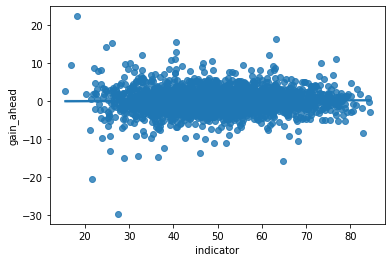

In [36]:
ppower = CPredictivePower(cdataframe, indicator)
ppower.estimate()
ppower._dataframe.get().tail(2)
dataframe = ppower.build_a_new_dataframe()
dataframe["gain_ahead"] = dataframe.gain_ahead * 100

sns.regplot(dataframe.indicator, dataframe.gain_ahead);

### Spliting indicator values into buckets (20 buckets)

Let'me explain, in this case we will if the value of indicator(rsi) is beetween 0-5 returns will be grouped and calculate the mean/sum of returns ahead.

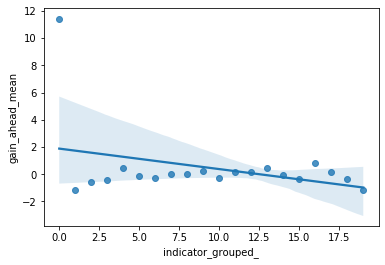

In [37]:
sns.regplot(x="indicator_grouped_", y="gain_ahead_mean", data=ppower.sort_and_binned_data(dataframe));

#### Using sum of returns
Now, instead use mean of returns i use the sum of returns, as doctor howard describe in his book.

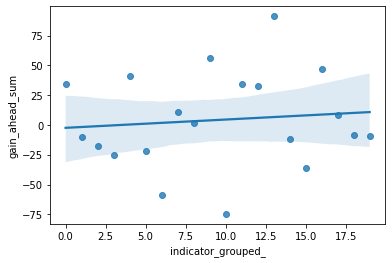

In [38]:
dataframe["indicator_grouped"] = pd.cut(dataframe.indicator, 20, labels=False)
df_grouped = dataframe.groupby(["indicator_grouped"]).agg(
    {"gain_ahead": "sum", "indicator":["min", "max"]}).reset_index()
df_grouped.columns = ["_".join(column) for column in df_grouped.columns.ravel()]
sns.regplot(x="indicator_grouped_", y="gain_ahead_sum", data=df_grouped);

### Display de predictive power of indicator for a group of indicator and stocks with timeframes
* First char is grouped and sorted by selected returns 
* Second one is sorted by R² of regression, used to mesure the predictive power

In [24]:
from helpers import *

indicators = IndicatorsFactory().build_from_dict(indicators_names())

results = build_predictive_power_for_group_stocks_and_indicators(cdataframes, indicators)
results.sort_values(["ols_r_squared"], ascending=False).head(2)

,selected_start_value,selected_end_value,selected_returns,max_returns,ols_r_squared,data,indicator_name,indicator_params,ticker,timeframe,indicator_period
32,-12.122371,-11.225659,0.045804,0.045804,0.440569,"{'ticker': 'ITUB4', 'timeframe': 'H1'}",roc,{'period': 1},ITUB4,H1,{period: 1}
27,-15.108977,-14.058777,0.008895,0.012821,0.432179,"{'ticker': 'ITUB4', 'timeframe': 'H1'}",roc,{'period': 5},ITUB4,H1,{period: 5}


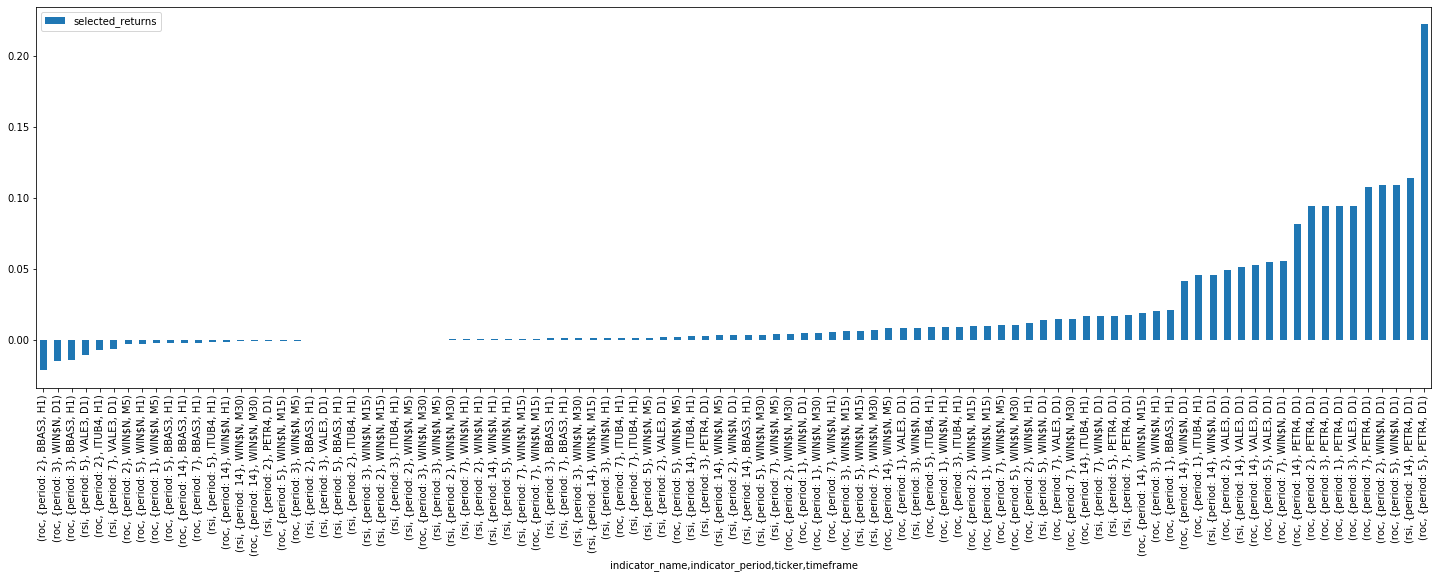

In [25]:
results.groupby(
    ["indicator_name", "indicator_period", "ticker", "timeframe"])[["selected_returns"]].mean().sort_values(["selected_returns"]).plot(figsize=(25,7), kind="bar");

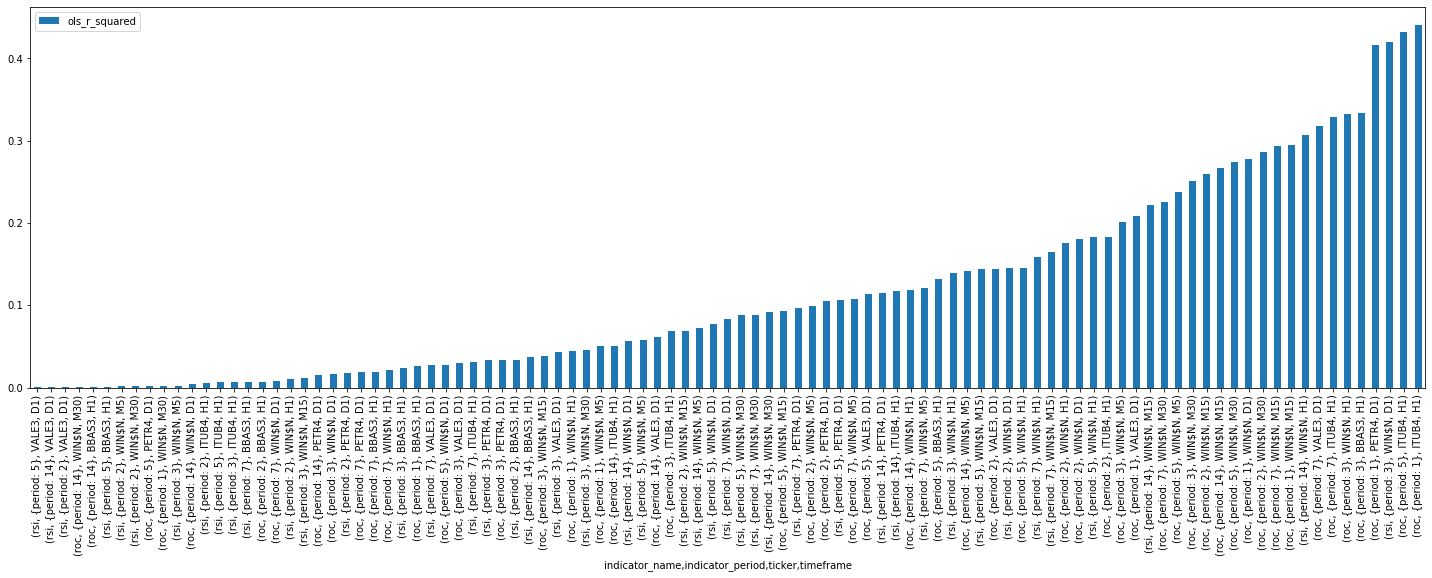

In [10]:
results.groupby(
    ["indicator_name", "indicator_period", "ticker", "timeframe"])[["ols_r_squared"]].mean().sort_values(["ols_r_squared"]).plot(figsize=(25,7), kind="bar");